In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/MATH 497 Subteam 3'

/content/drive/.shortcut-targets-by-id/1NMcVSJNgcvd_lge3xXnubVhTrB0MrqUC/497 - Peanut Butter Research Group


In [ ]:
%ls

'Code Files & Github'/              'Leader Applications'/  'Team Activities'/
'Descriptive Stats'/                 LeadWater/
'HMM - Mean Differences of Draws'/  'Project Formulation'/


In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 KB 6.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import matplotlib as mpl
import matplotlib.cm as cm

### Data Cleaning/Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MATH 497 Subteam 3/LeadWater/relative_differences_sequential_data.csv')

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
draw_cols = list(df.columns)[2:]
draw_cols

['x1x2',
 'x2x3',
 'x3x4',
 'x4x5',
 'x5x6',
 'x6x7',
 'x7x8',
 'x8x9',
 'x9x10',
 'x10x11']

In [ ]:
# sort by date 
df['Date.Sampled'] = pd.to_datetime(df['Date.Sampled'])
df.sort_values(by='Date.Sampled', inplace=True)


# calculate average differences 
draws_only = df[draw_cols]
avg_dif = draws_only.mean(axis=1)
df['avg_dif'] = avg_dif

In [ ]:
df

,Date.Sampled,Address,x1x2,x2x3,x3x4,x4x5,x5x6,x6x7,x7x8,x8x9,x9x10,x10x11,avg_dif
432,2016-02-28,27XX N Wilton Ave**,0.152466,0.159533,0.124161,0.134328,0.050000,-0.040100,-0.080940,-0.110795,-0.162939,-0.259542,-0.003383
960,2016-03-04,54XX S Harper Ave***,0.532847,0.085714,-0.153509,-0.248705,-0.262069,-0.128037,-0.202572,-0.104839,-0.130631,-0.386874,-0.099867
1374,2016-03-04,81XX S Euclid Ave,-0.576271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.057627
117,2016-03-16,11XX W George St,0.061174,0.270588,-0.166667,0.046667,0.093418,0.019417,-0.116190,-0.332974,-0.176090,0.072549,-0.022811
1463,2016-03-25,92XX S Dauphin Ave,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,2022-04-08,91XX S Leaveitt Ave,0.040123,0.329377,-0.129464,-0.123077,-0.087719,-0.019231,-0.071895,-0.070423,-0.106061,-0.127119,-0.036549
397,2022-04-08,25XX N Sheffield Ave**,0.253061,-0.224756,0.323529,1.050794,0.126935,0.092033,0.215094,0.490683,0.111111,-0.125000,0.231349
436,2022-04-11,27XX W Farwell Ave,-0.782927,-0.093633,0.033058,105.800000,-0.990936,0.206612,2.325342,0.175077,-0.123576,-0.677000,10.587202
1152,2022-04-13,62XX N Lakewood Ave,0.493018,0.438849,0.080000,0.083333,-0.055556,-0.045249,-0.080569,-0.051546,-0.255435,-0.778832,-0.017199


In [ ]:
df.dtypes

Date.Sampled    datetime64[ns]
Address                 object
x1x2                   float64
x2x3                   float64
x3x4                   float64
x4x5                   float64
x5x6                   float64
x6x7                   float64
x7x8                   float64
x8x9                   float64
x9x10                  float64
x10x11                 float64
avg_dif                float64
dtype: object

#### Time Series Plot (Average Relative Difference vs Date Sampled)

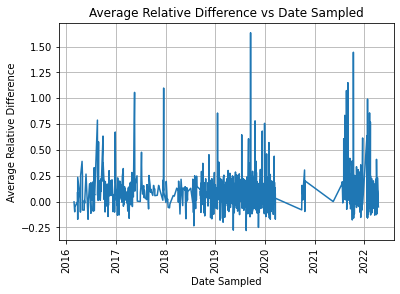

In [ ]:
# drop outliers for visibility
df.drop(df[df['avg_dif'] > 2].index, inplace=True)

plt.plot(df['Date.Sampled'], df['avg_dif'])
plt.title('Average Relative Difference vs Date Sampled')
plt.xlabel("Date Sampled")
plt.ylabel('Average Relative Difference')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## HMM Implementation

In [ ]:
X = df[['avg_dif']].values

In [ ]:
np.random.seed(42)

In [ ]:
X.shape

(1530, 1)

In [ ]:
# Define the maximum number of hidden states to consider
max_states = 5

# Compute the AIC for each number of hidden states
aics = []
for n_states in range(1, max_states+1):
    # Initialize the HMM with the current number of hidden states
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
    # Train the HMM using the observed data
    model.fit(X)
    # Compute the negative log-likelihood of the data under the model
    neg_log_likelihood = -model.score(X)
    # Compute the AIC for the model
    aic = 2 * n_states - 2 * neg_log_likelihood
    # Add the AIC to the list of AICs
    aics.append(aic)

# Select the number of hidden states that minimizes the AIC
best_n_states = np.argmin(aics) + 1

# Train the HMM with the selected number of hidden states
model = hmm.GaussianHMM(n_components=best_n_states, covariance_type="full")
model.fit(X)

GaussianHMM(covariance_type='full')

In [ ]:
Z = model.predict(X)
states = pd.unique(Z)

In [ ]:
print('List of Hidden States')
print(states)
print('-'*8)
print('Initial Probabilities')
print(model.startprob_)
print('-'*8)
print("Transition Matrix")
print(model.transmat_)
print('-'*8)
print('Mean')
print(model.means_)
print('-'*8)
print('Covariance')
print(model.covars_)
print('-'*8)


List of Hidden States
[0]
--------
Initial Probabilities
[1.]
--------
Transition Matrix
[[1.]]
--------
Mean
[[0.09145415]]
--------
Covariance
[[[0.0208959]]]
--------


Text(0, 0.5, 'draw_change')

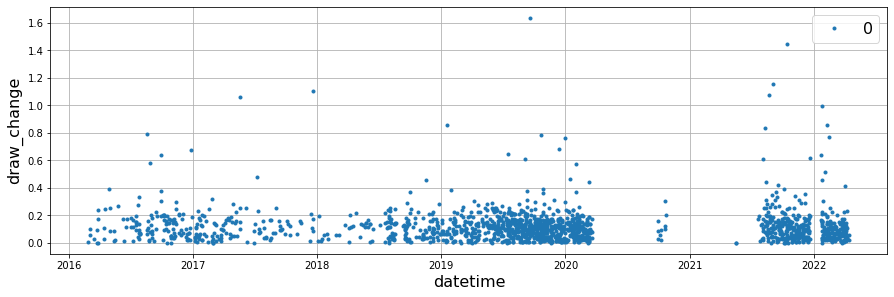

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = df["Date.Sampled"].iloc[want]
    y = X[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("draw_change", fontsize=16)

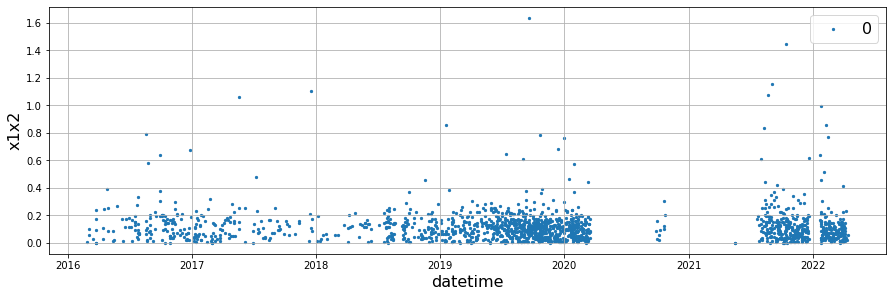

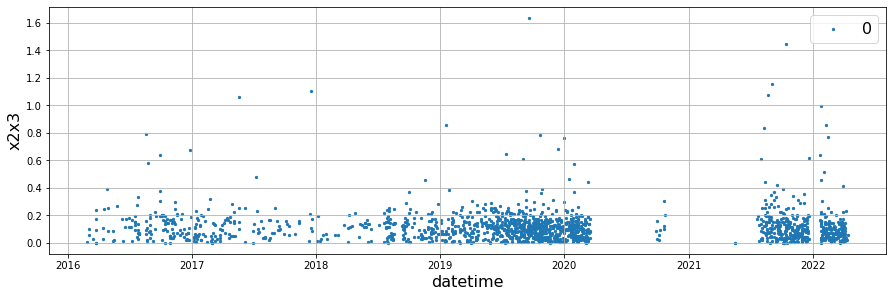

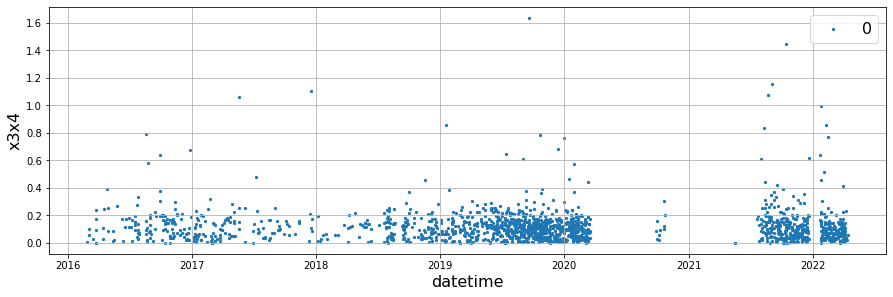

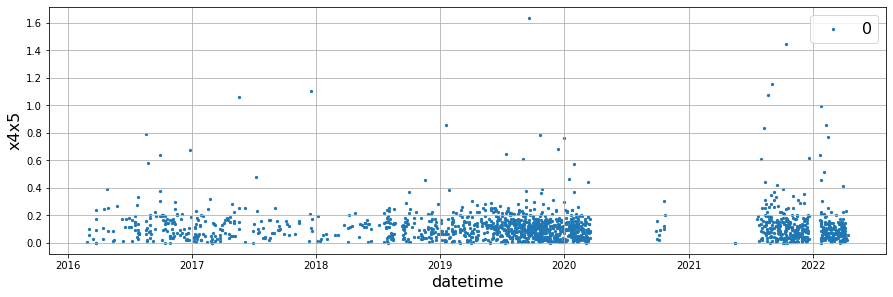

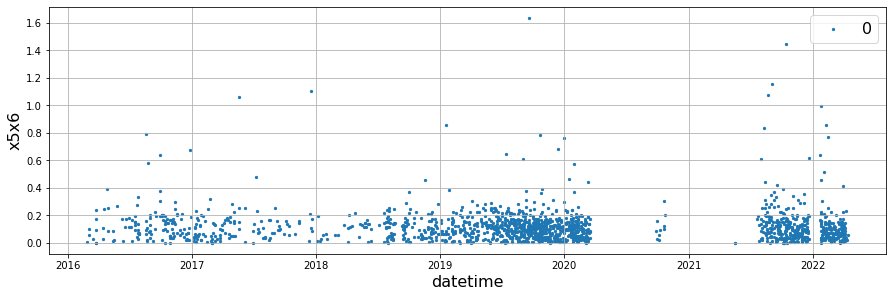

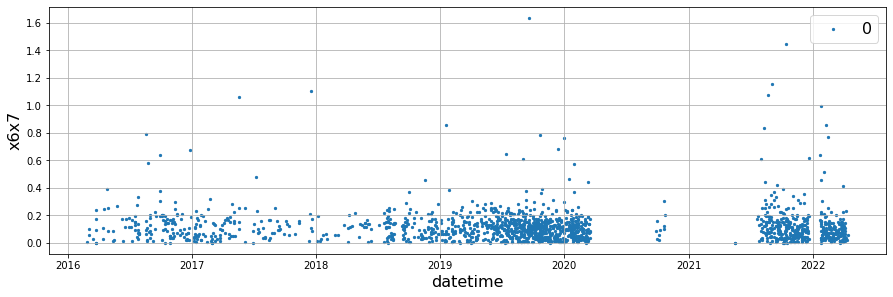

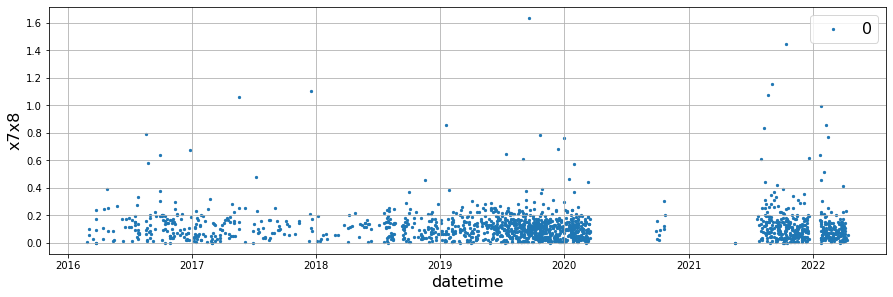

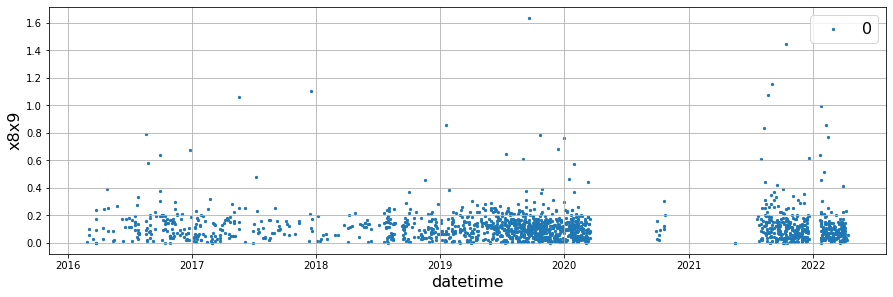

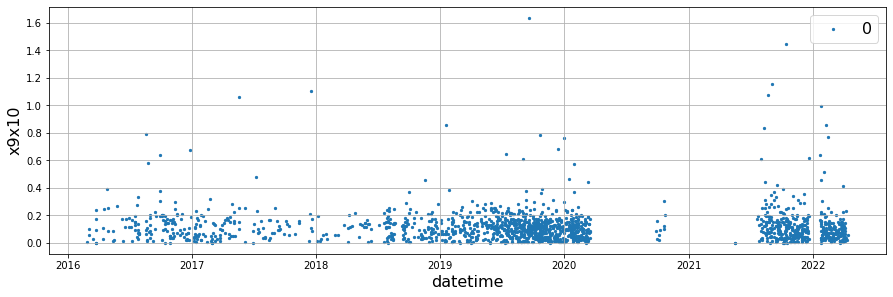

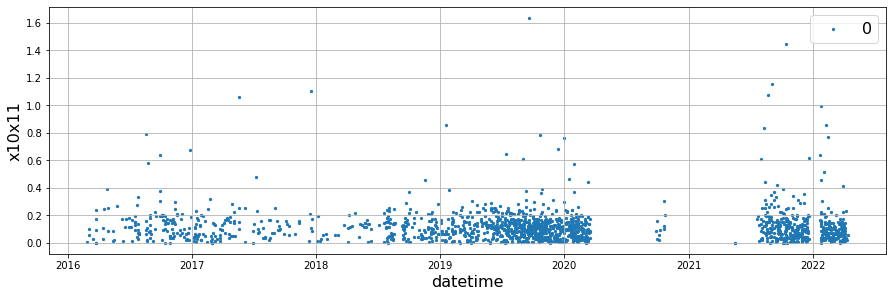

In [ ]:
for j in range(len(draw_cols)):
    plt.figure(figsize = (15, 10))
    plt.subplot(2,1,1)
    for i in states:
        want = (Z == i)
        x = df["Date.Sampled"].iloc[want]
        y = X[want]
        plt.scatter(x, y, s=5)
    plt.legend(states, fontsize=16)
    plt.grid(True)
    plt.xlabel("datetime", fontsize=16)
    plt.ylabel(draw_cols[j], fontsize=16)